In [24]:
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import cv2
import colorsys

In [25]:
def show_mask(mask: np.ndarray, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box: np.ndarray, ax, color: str | list[float]="green"):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=color, facecolor=(0,0,0,0), lw=2))

In [26]:
def mulit_colors(num_classes: int):
    #---------------------------------------------------#
    #   https://github.com/bubbliiiing/yolov8-pytorch/blob/master/yolo.py#L88
    #   画框设置不同的颜色
    #---------------------------------------------------#
    #             (hue, saturation, value)
    hsv_tuples = [(x / num_classes, 0.6, 1.) for x in range(num_classes)]
    # colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = [colorsys.hsv_to_rgb(*x) for x in hsv_tuples]
    # colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    colors = [(x[0], x[1], x[2]) for x in colors]
    return colors

# Image

In [3]:
image = cv2.imread(r"wallpapers/bus.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(1080, 810, 3)

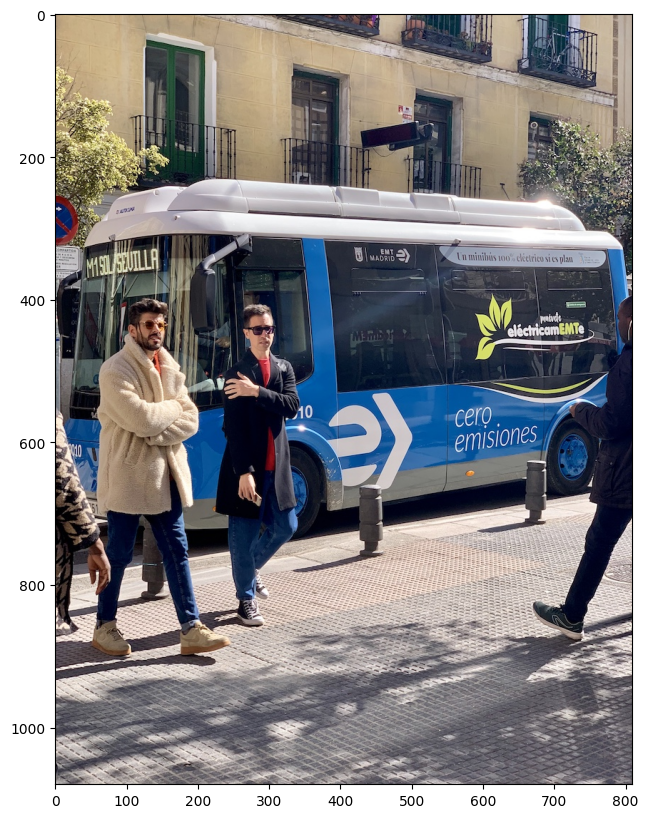

In [31]:
plt.figure(figsize=(10, 10))
plt.imshow(image)

# yolo
https://github.com/ultralytics/ultralytics

```
git clone https://github.com/ultralytics/ultralytics
cd ultralytics
pip install -v -e .
```

In [5]:
# yolov8s.pt在segment-anything根目录
yolo = YOLO("yolov8s.pt")

In [6]:
results: list = yolo(image)


0: 640x480 4 persons, 1 bus, 44.1ms
Speed: 1.3ms preprocess, 44.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


In [58]:
xyxys = results[0].boxes.xyxy
xyxys.cpu().numpy()

array([[     15.715,      230.05,       803.4,      751.65],
       [     668.62,      388.93,      809.52,      877.26],
       [     50.789,      399.26,      243.88,      902.38],
       [     222.25,      407.42,      345.05,      860.76],
       [    0.18062,      549.58,      61.686,      870.77]], dtype=float32)

In [59]:
confs = results[0].boxes.conf
confs.cpu().numpy()

array([    0.89302,     0.88603,     0.88056,     0.87822,     0.69117], dtype=float32)

In [36]:
clses = results[0].boxes.cls

In [10]:
names = results[0].names

In [11]:
names[results[0].boxes.cls.cpu().numpy()[0]]

'bus'

In [28]:
colors = mulit_colors(len(names))

# SAM

In [12]:
from segment_anything import sam_model_registry, SamPredictor

In [13]:
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda"

In [14]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [15]:
predictor = SamPredictor(sam)

In [16]:
predictor.set_image(image)

In [17]:
transformed_boxes = predictor.transform.apply_boxes_torch(results[0].boxes.xyxy, original_size=image.shape[:2])

In [18]:
masks, scores, logits = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [19]:
masks.shape

torch.Size([5, 1, 1080, 810])

In [20]:
scores

tensor([[0.9901],
        [0.9747],
        [0.9715],
        [0.9466],
        [0.9560]], device='cuda:0')

bus: 0.89
person: 0.89
person: 0.88
person: 0.88
person: 0.69


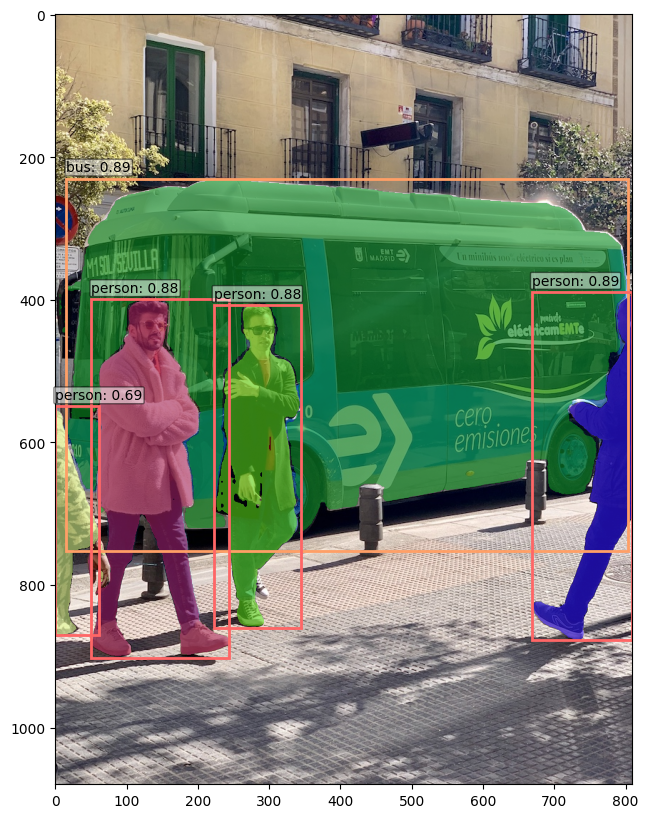

In [60]:
plt.figure(figsize=(10,10))
plt.imshow(image)
for mask in masks.cpu().numpy():
    show_mask(mask, plt.gca(), random_color=True)
for xyxy, conf, cls in zip(xyxys.cpu().numpy(), confs.cpu().numpy(), clses.cpu().numpy().astype(np.int64)):
    show_box(xyxy, plt.gca(), colors[cls])
    print(f"{names[cls]}: {conf:.2f}")
    # https://blog.csdn.net/TeFuirnever/article/details/88947248
    plt.text(xyxy[0],
             xyxy[1]-10 if xyxy[1] > 10 else xyxy[1]+20,
             f"{names[cls]}: {conf:.2f}",
             fontdict = dict(fontsize=10, color="black"),
             bbox=dict(boxstyle='round,pad=0.1', fc='white', ec='k',lw=1 ,alpha=0.5) # 文字背景
             )